<p style="font-size:14pt;text-align:center;">
Train YOLO network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys
import simplejson

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
from lasagne import nonlinearities
from lasagne import layers
    
import bnr_ml.objectdetect.yolo as yolo
from bnr_ml.objectdetect import utils

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.json', 'r') as f:
    annotations = simplejson.load(f)

In [3]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for a in annotations:
        for obj in a['annotations']:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [4]:
def fix_labels(annotations):
    for a in annotations:
        a['image'] = '/usr/local/python/bnr_ml/data/PascalVOC/' + a['image']
        new_objs = []
        for obj in a['annotations']:
            lab = obj['label'].lower()
            if 'car' in lab:
                lab = 'car'
            elif 'person' in lab:
                lab = 'person'
            elif 'bike' in lab:
                lab = 'bike'
            elif 'bicycle' in lab:
                lab = 'bicycle'
            else:
                lab = None
                
            if lab != None:
                obj['label'] = lab
                new_objs.append(obj)
        a['annotations'] = new_objs
    return annotations

In [5]:
annotations = np.asarray(fix_labels(annotations))

In [6]:
counts = get_label_counts(annotations)

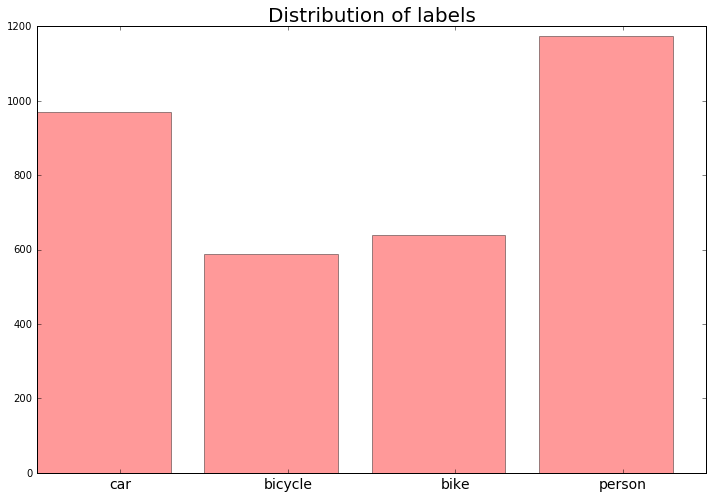

In [7]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [8]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [9]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [10]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [11]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] = np.float_(coord[[0,2]]) / old_size[1]
        coord[[1,3]] = np.float_(coord[[1,3]]) / old_size[0]
#         if coord[2] >= coord[0]:
#             coord[2] -= coord[0]
#         else:
#             coord[2] = coord[0] - coord[2]
#         if coord[3] >= coord[1]:
#             coord[3] -= coord[1]
#         else:
#             coord[3] = coord[1] - coord[3]
        
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
#     annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.shape[0], batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.shape[0] - i)):
            annotation = annotations[i+j]
            objs = annotation['annotations']
            im = imread(annotation['image'])
            old_size = np.float_(annotation['size'])
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray([
                            obj['x'],
                            obj['y'],
                            obj['w'],
                            obj['h']
                        ], dtype=theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [12]:
def generate_data_3(annotations, C, max_objs=15, size=(200,200), batch_size=100, augment=10):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for num in range(augment):
        for i in range(0,annotations.size, batch_size):
            Xbatch = np.zeros((batch_size,3) + size)
            ybatch = np.zeros((batch_size, (4 + C) * max_objs))

            for j in range(min(batch_size, annotations.size - i)):
                objs = annotations[i+j][annotations]
                im = imread(annotations[i+j]['image'])
                old_size = im.shape
                
                old_box = Box(0.,0.,1.,1.)
                iterlap = .8
                new_width = iterlap + (1. - iterlap) * np.random.rand()
                new_height = iterlap +  (1. - iterlap) * np.random.rand()
                new_xi = (1. - new_width) * np.random.rand()
                new_yi = (1. - new_height) * np.random.rand()
                new_box = Box(
                    new_xi,
                    new_yi,
                    new_width + new_xi,
                    new_height + new_yi
                )
                im = new_box.subimage(im)

                im = reformat_image(im, size)
                
                im = rgb2hsv(im)
                im[:,:,[0,2]] *= (1 + .1 * np.random.rand(1,1,2))
                im = hsv2rgb(im)
                
                Xbatch[j] = im.swapaxes(2,1).swapaxes(1,0)

                for k in range(max_objs):
                    if k < objs.__len__():
                        obj = objs[k]
                        coord = np.asarray([
                                obj['x'],
                                obj['y'],
                                obj['w'],
                                obj['h']
                            ])
#                         coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                        coord = transform_coord(coord, old_size, size)
                        
                        obj_box = Box(coord[0], coord[1], coord[0] + coord[2], coord[1] + coord[3])
                        
                        if new_box.iou(obj_box) > 0.5:
                            coord[0] -= new_box.xi
                            coord[1] -= new_box.yi
                            coord[[0,2]] /= (new_box.xf - new_box.xi)
                            coord[[1,3]] /= (new_box.yf - new_box.yi)
                            ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                            ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                        else:
                            ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

                    else:
                        ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

            yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [13]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [534]:
S = (2,2)
B = 2
C = 4

In [535]:
num_epochs = 1000
batch_size = 15
input_shape = (180,180)

In [656]:
test_network = False
if test_network:
    gen = generate_data_2(train_annotations[100:110], C, max_objs=5, size=input_shape)
    data = [g for g in gen]
    Xtest, ytest = data[0][0], data[0][1]
    Xtest, ytest = theano.shared(Xtest), theano.shared(ytest)
    input_var = Xtest
else:
    input_var = None

In [657]:
import lasagne.nonlinearities as nonlinearities

In [658]:
net = {}
net['input'] = InputLayer((None, 3) + input_shape, input_var=input_var)
net['conv1_1'] = Conv2DLayer(net['input'], 64, 3, pad=1, stride=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv1_2'] = Conv2DLayer(net['conv1_1'], 64, 3, pad=1, stride=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool1'] = Pool2DLayer(net['conv1_2'], 2)
net['conv2_1'] = Conv2DLayer( net['pool1'], 128, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv2_2'] = Conv2DLayer(net['conv2_1'], 128, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool2'] = Pool2DLayer(net['conv2_2'], 2)
net['conv3_1'] = Conv2DLayer(net['pool2'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv3_2'] = Conv2DLayer(net['conv3_1'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv3_3'] = Conv2DLayer(net['conv3_2'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool3'] = Pool2DLayer(net['conv3_3'], 2)
net['conv4_1'] = Conv2DLayer(net['pool3'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv4_2'] = Conv2DLayer(net['conv4_1'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv4_3'] = Conv2DLayer(net['conv4_2'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool4'] = Pool2DLayer(net['conv4_3'], 2)
net['conv5_1'] = Conv2DLayer(net['pool4'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv5_2'] = Conv2DLayer(net['conv5_1'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv5_3'] = Conv2DLayer(net['conv5_2'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool5'] = Pool2DLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=2048, nonlinearity=None)
net['fc6_dropout'] = dropout(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=2048, nonlinearity=None)
net['fc7_dropout'] = dropout(net['fc7'], p=0.5)
# net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
# net['prob'] = NonlinearityLayer(net['fc8'], nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [539]:
load_pretrained = True
if load_pretrained:
    with open('/usr/local/python/bnr_ml/data/pretrained/vgg16.pkl', 'rb') as f:
        weights = pk.load(f)['param values']
        lasagne.layers.set_all_param_values(net['conv5_3'], weights[:-6])

<b>Add extra layers to network for detection</b>

In [659]:
# net['fc6'] = DenseLayer(net['pool5'], 2048, nonlinearity=None)
net['output'] = DenseLayer(net['fc6_dropout'], (B * (C + 1) + 4) * (S[0] * S[1]), nonlinearity=None)
# net['output'] = DenseLayer(dropout(net['dense1'], p=.0), (B * 5 + C) * S[0]*S[1])

In [660]:
load_weights = True
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [661]:
import bnr_ml.utils.nonlinearities as nonlin

In [662]:
reload(nonlin)
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [663]:
yl = yolo.YoloObjectDetector(net, (None, 3) + input_shape, C, S, B) 

In [664]:
gen_fn = lambda ann, shape, batch_size: generate_data_2(ann, C, size=shape, batch_size=batch_size)

cost = yl._get_cost(yl.output_test, ytest, S, B, C, lmbda_noobj=0., rescore=True)

In [749]:
train_loss, test_loss = yl.train(
    gen_fn,
    train_annotations[:],
    test_annotations[:],
    lr=1e-6,
    momentum=0.9,
    batch_size=batch_size,
    epochs=4000,
    rescore=True,
    lmbda_noobj=1.,
)

Getting cost...
> /usr/local/python/bnr_ml/objectdetect/yolo.py(267)_get_cost()
-> return cost, [iou]
(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/yolo.py(267)_get_cost()
-> return cost, [iou]
(Pdb) c
Creating cost variable took 1.5306 seconds
Compiling...


  0%|          | 0/4000 [00:00<?, ?it/s]

Compiling functions took 44.6982 seconds
Beginning training...
2.3891708374
2.18174769084
2.86954320272
2.30403442383
2.24980010986
1.93768234253
2.23545455933
2.17867940267
2.14730936686
2.24942347209
2.44269078573
1.94960746765
1.91503117879
1.7182047526
1.67605934143
1.87537854513
1.84195849101
1.90862795512
1.99958813985
1.67614568075
2.65490824382
2.28783874512
2.70476760864
2.67886454264
1.89431635539
2.25490773519
1.48762868245
2.05842882792
2.30812327067
1.97310562134
3.24941126506
2.00539016724
1.78487421672
2.302247111
2.09952214559
2.18801345825
1.6097539266
2.26209665934
2.47434488932
3.00821533203
1.69737447103
2.05971603394
2.09779179891
2.04437204997
2.72641398112
2.21979955037
2.29700978597
2.81510518392
2.6160349528
1.57178395589
1.89823379517
2.15450973511
1.55741818746
1.57964121501
1.51087926229
1.6041276296
1.55967203776
2.16700083415
3.30626475016
2.55468012492
2.01060600281
1.96533940633
1.98605817159
2.65146280924
2.17662226359
2.48155186971
2.38392944336
2.2188

  0%|          | 1/4000 [08:59<599:18:58, 539.52s/it]

Epoch 0
------
Train Loss: 2.1440, Test Loss: 2.5075
2.44491424561
2.05018831889
1.91045392354
2.86288401286
1.63486760457
1.77168566386
2.15463638306
1.87554906209
2.22719116211
2.21053644816
2.16628723145
2.86902109782
2.40138600667
1.74559237162
2.992750295
2.19930928548
2.54581349691
1.66875241597
1.90225550334
1.54624379476
2.33895314535
1.97584673564
2.46131439209
2.29298375448
1.74867172241
1.85073115031
1.93187103271
2.15299886068
2.27705027262
1.65215161641
2.97182159424
1.71258913676
1.93321711222
1.85228462219
2.96868209839
2.21602300008
2.30305480957
2.38946329753
1.72862764994
2.04857660929
1.92434183757
1.98785527547
2.76417363485
2.0348227183
2.05641148885
2.91956354777
2.19609934489
1.83315264384
1.4578318278
2.0928817749
1.73097674052
2.63375498454
1.91068636576
2.65328470866
2.14120814006
2.14181060791
2.62970962524
2.00424435933
2.19714991252
1.9709409078
1.46196683248
2.11233901978
2.28240102132
2.2811185201
1.82909228007
1.70847752889
1.80843925476
2.15993754069
2.

  0%|          | 2/4000 [18:01<600:01:44, 540.30s/it]

Epoch 1
------
Train Loss: 2.1301, Test Loss: 2.4908
2.34155502319
2.08967170715
2.24176381429
2.48487014771
3.12223790487
2.27203521729
1.88337478638
2.08978385925
2.17176259359
1.65579579671
2.35838902791
2.35859731038
2.15994898478
2.08963088989
2.30088246663
1.67223154704
1.8632715861
1.94121500651
1.85616378784
2.58390299479
1.52727203369
2.01986223857
2.21700515747
2.01075871785
1.97678515116
1.75370292664
2.85785776774
2.13887151082
1.92104110718
2.91296691895
2.43793106079
2.30253728231
1.89480730693
2.49452667236
2.31131947835
2.17756245931
1.68016738892
2.48398386637
2.58824691772
2.14729181925
2.55533803304
1.77964553833
3.2155804952
2.63584493001
1.73393758138
3.01896158854
1.79877255758
1.99399859111
2.07332522074
1.89910736084
1.65926170349
2.4006362915
2.44896621704
3.07436396281
1.89378178914
1.7411500295
1.50982691447
2.62196985881
1.86221974691
2.57948684692
1.65406506856
1.98254865011
1.80841293335
1.65578689575
1.85254605611
1.8002591451
2.25814336141
2.01295623779


  0%|          | 3/4000 [27:04<600:50:30, 541.16s/it]

Epoch 2
------
Train Loss: 2.1338, Test Loss: 2.4872
1.76270929972
2.50186208089
1.83877080282
1.93837229411
1.9401473999
1.76040649414
2.56515630086
2.69152170817
1.68453877767
1.80145072937
2.78237024943
2.64117736816
2.19637400309
1.75798835754
1.66718991597
2.57756754557
2.18173472087
2.30945510864
2.21882705688
1.78460489909
2.22231852214
2.23003082275
1.85166575114
2.01736793518
3.05207977295
2.5959660848
1.9950764974
2.08770370483
1.85674146016
2.8394124349
2.17807490031
2.15472946167
2.09787661235
2.39800745646
2.1346728007
1.89725023905
1.84025039673
2.63889770508
1.52685127258
2.35135955811
2.45725733439
1.67705281576
1.80773722331
2.1661684672
1.99438298543
2.40744934082
1.73939412435
2.13186086019
2.12511469523
2.0366394043
1.67426134745
2.30713094076
1.60748748779
1.73218638102
1.83020095825
1.91755994161
1.62831853231
2.0493976593
2.61300557454
1.55664812724
2.18564783732
1.56287638346
1.7431930542
2.28866958618
2.62620061239
2.01315333049
1.85313835144
3.00136845907
2.38

  0%|          | 4/4000 [36:07<601:10:33, 541.60s/it]

Epoch 3
------
Train Loss: 2.1317, Test Loss: 2.5310
1.80142033895
1.87946383158
2.02543385824
1.92584177653
2.71463114421
1.97102597555
2.05046437581
2.71886189779
2.68467178345
1.99195454915
1.97484461466
1.98264147441
2.90354385376
2.40479685465
1.61852035522
3.10274429321
2.60929082235
1.69112993876
2.07460428874
2.68466873169
1.94510523478
1.66575597127
1.63020655314
1.64482549032
2.56179173787
2.23943430583
1.79349009196
2.52815450033
1.80809491475
2.1119275411
2.50232645671
1.98266792297
3.53453420003
1.62433408101
2.50151545207
2.53190155029
1.51088587443
1.80224520365
3.40482076009
1.85723317464
2.34804255168
2.02998059591
1.41412404378
1.64319966634
2.21666234334
1.97950375875
2.58264973958
2.96772689819
1.72652562459
2.15136489868
2.34657999674
2.3539276123
1.54170939128
2.53294932048
2.44015426636
1.89147618612
2.1180325826
2.32537740072
2.03016993205
1.39113375346
1.78184331258
2.17281621297
2.65412801107
1.82266031901
1.79504979451
2.43135655721
1.88981374105
1.7838609059

  0%|          | 5/4000 [45:09<601:12:46, 541.77s/it]

Epoch 4
------
Train Loss: 2.1235, Test Loss: 2.5215
2.18151906331
1.72895787557
1.82128156026
1.74046707153
2.50930608114
2.4571123759
2.1180829366
2.59486999512
2.10092798869
2.65663121541
1.98827298482
1.54066988627
2.01657562256
2.30797170003
2.41946105957
1.74317970276
1.76575686137
1.66481488546
1.99545021057
2.04579073588
2.22903722127
2.06159159342
1.375548172
1.68907826742
1.94960123698
1.90716438293
1.53982276917
2.08968556722
1.93887290955
2.09271850586
1.96053466797
1.51504554749
2.19761988322
1.96944122314
2.42403717041
1.48899548848
1.63593800863
3.22800928752
1.65225499471
2.41344909668
2.35215454102
3.72965011597
1.98304392497
1.93217035929
2.05143788656
1.9095606486
1.44873224894
2.12898763021
2.38380508423
1.7218401591
2.03897476196
1.99283040365
1.97207183838
2.53875427246
2.35405731201
2.08324953715
2.1582262675
3.03920669556
1.9544207255
2.22326990763
2.01038297017
2.7658917745
1.58966763814
3.0799176534
2.50865097046
2.52660598755
1.95201848348
3.21927286784
2.746

  0%|          | 6/4000 [54:11<601:07:54, 541.83s/it]

Epoch 5
------
Train Loss: 2.1029, Test Loss: 2.5278
1.3139784495
2.07746518453
1.49670333862
3.63927205404
1.9778330485
1.6598080953
1.63900769552
2.70456924438
2.07359631856
1.61292088826
1.79830767314
1.63074658712
1.85194180806
2.25414632161
2.43806381226
1.63236897786
2.07578837077
2.3685508728
1.81900723775
1.92468249003
1.63433914185
2.60507049561
1.58366711934
1.72336667379
1.88949356079
2.28843027751
2.56161015828
1.6657564799
2.61122919718
1.72269477844
3.30548629761
2.13695017497
2.08774375916
1.67220446269
2.18861287435
1.56746788025
1.67367223104
2.88462880452
2.21991500854
1.52407493591
1.87295811971
2.68637364705
1.81429735819
1.73162727356
3.05637919108
2.72593816121
1.96769968669
1.89933013916
1.72023862203
2.04517033895
2.74760716756
2.02421277364
2.26489944458
2.36611633301
2.14905268351
1.66809565226
2.28316141764
2.06088994344
1.60489934285
1.94951782227
1.74408671061
2.28454945882
1.71641159058
2.20230458577
3.14288584391
2.20813446045
2.54854660034
2.98799463908


  0%|          | 7/4000 [1:03:13<601:04:33, 541.92s/it]

Epoch 6
------
Train Loss: 2.0818, Test Loss: 2.5197
1.70716883341
1.43118591309
1.90370979309
1.55521176656
2.02690404256
2.01910909017
2.69034245809
1.95915184021
1.88615264893
1.7595568339
1.44868011475
2.3537747701
1.87230962118
2.16486994425
1.80300559998
2.43812128703
1.63831812541
2.2665898641
2.21299794515
2.0101234436
2.3684735616
1.54617029826
2.6423828125
2.53422470093
2.08627675374
2.25998814901
1.80543696086
2.14761021932
2.12388687134
1.48996671041
2.03327115377
1.75637715658
2.0159769694
1.39047889709
1.76510149638
2.37857055664
1.77020238241
1.99616228739
1.84394391378
2.18022435506
2.03930511475
2.34620666504
2.76913146973
2.09918022156
2.02699267069
1.66517003377
2.23860295614
3.26295013428
1.74686292013
1.90770975749
1.36830469767
2.5995686849
1.87461764018
1.8732161204
1.82483418783
3.30069605509
1.93119862874
2.29785715739
1.44294459025
2.06925392151
1.90105908712
2.27396621704
2.61820755005
2.17209650675
3.00811945597
2.51335576375
1.45858345032
2.88290049235
2.76

  0%|          | 8/4000 [1:12:15<600:56:02, 541.92s/it]

Epoch 7
------
Train Loss: 2.0933, Test Loss: 2.5149
1.82276852926
1.5902545929
2.01497306824
1.72793223063
1.97737490336
1.99788614909
1.95737762451
2.43000513713
2.88636423747
1.99496002197
1.77914683024
2.38061904907
1.68282101949
2.12079226176
2.3241317749
2.14160207113
2.28683954875
2.92465820312
1.94864997864
1.94421971639
1.78935953776
1.61258366903
2.41286595662
2.63711725871
1.70623931885
2.57128016154
2.44808019002
2.0786790212
1.65344645182
2.48089294434
1.98135515849
1.85707422892
2.44590657552
1.86079470317
2.40937652588
2.56052118937
2.54381205241
1.54684804281
1.60063781738
1.98179690043
1.96395746867
1.71196746826
2.34542236328
2.13924967448
2.23823140462
2.72364705404
1.70164133708
2.36038462321
2.51922276815
1.78949050903
2.4103729248
2.1220820109
2.73210245768
1.77311477661
2.07465349833
2.09827626546
1.83811365763
1.8389348348
1.70030759176
2.13691584269
1.74666264852
2.67146174113
2.45848185221
2.74554926554
2.06405779521
1.92497406006
2.39843521118
2.05907783508
2

  0%|          | 9/4000 [1:21:12<599:14:37, 540.54s/it]

Epoch 8
------
Train Loss: 2.0889, Test Loss: 2.5104
2.12164421082
2.00827471415
1.6842444102
2.26155268351
2.01942113241
2.98576431274
1.70372467041
1.41261456807
1.96502240499
3.18355687459
2.52803853353
1.77932167053
1.74505818685
2.12660713196
2.08780225118
1.96244850159
2.11523920695
1.56676177979
1.44231046041
1.62836850484
1.88026199341
2.6110206604
2.27557830811
2.33048858643
3.12164052327
2.244506073
1.7166730245
2.15033213298
1.65327275594
2.19926274618
2.07570966085
2.68162333171
1.69611549377
1.71461753845
1.57353197734
2.17274576823
2.18388468424
2.33233998617
1.80375455221
1.97896092733
1.89597066243
1.7520207723
2.33873825073
2.12655067444
2.11080856323
2.7544804891
2.22241007487
1.85164515177
1.58545888265
1.70625508626
2.44187164307
1.6119430542
2.00850575765
2.6810508728
2.10229390462
1.43684844971
2.16391143799
2.49492034912
2.71096293132
1.8458471934
2.39093729655
2.9369354248
1.50858179728
2.58612874349
1.56620394389
2.4181523641
1.68544553121
2.25206171672
1.86629

  0%|          | 10/4000 [1:30:02<595:33:07, 537.34s/it]

Epoch 9
------
Train Loss: 2.0784, Test Loss: 2.5178
2.01442451477
2.69169718424
2.71251144409
1.93448588053
2.34209391276
1.86581293742
1.78485641479
1.88532981873
2.11567115784
1.74861831665
1.81019922892
2.03021469116
1.79675738017
2.92054824829
1.63421579997
1.95067850749
1.80219408671
2.97825164795
1.53454767863
2.13430124919
1.98367156982
2.51377639771
2.65404993693
1.43703168233
1.87478841146
1.70309193929
2.33046646118
1.75781313578
2.0146783193
1.7378133138
1.70157521566
2.04800262451
1.91532249451
2.06442146301
3.01098302205
2.25135142008
2.2192179362
3.0001546224
1.89408098857
2.31155700684
2.08226598104
1.88664271037
2.65887324015
2.44955393473
1.87953580221
1.48914006551
1.66298268636
2.12410405477
1.66683425903
1.43382670085
2.61533330282
2.09233856201
2.72781295776
1.77991015116
2.64609807332
1.93946736654
1.39014053345
2.09355786641
2.15116348267
1.890843455
2.48278249105
1.61365076701
2.99936828613
2.86093292236
1.55170199076
3.08443272909
2.44540888468
1.61673520406
2

  0%|          | 11/4000 [1:38:56<594:04:36, 536.14s/it]

Epoch 10
------
Train Loss: 2.0851, Test Loss: 2.5006
2.52041168213
1.84204330444
1.98426157633
1.76756413778
2.12936719259
1.88399772644
1.92258021037
1.76198476156
1.51101366679
1.85869458516
2.57973251343
2.40508422852
2.28650970459
1.57274729411
2.82987772624
1.58013292948
2.01928571065
2.28676020304
1.47965660095
2.18402430216
1.4637550354
1.61048990885
2.65241953532
1.50178159078
1.71250406901
3.27697804769
2.696387736
3.20093994141
2.18664042155
1.90877583822
1.88561236064
2.22065404256
2.23316574097
1.99255282084
1.97423184713
2.76708552043
1.62223256429
1.89819552104
2.13291816711
1.91091550191
1.98567047119
2.73143335978
2.12178421021
1.82423477173
2.29507548014
1.7451868693
2.0378721873
2.00967216492
1.77450091044
2.17551930745
2.31285934448
2.18815612793
2.10314776103
2.57990849813
1.93624521891
2.34151967367
3.04948908488
1.59932721456
1.6110883077
1.39037055969
1.71673609416
1.75935045878
1.33532206217
2.25012817383
1.55011011759
2.01560312907
2.10893847148
1.70750528971


  0%|          | 12/4000 [1:47:49<592:54:45, 535.23s/it]

Epoch 11
------
Train Loss: 2.0780, Test Loss: 2.5130
2.00734799703
1.80850728353
1.90466969808
1.45829455058
2.84189122518
2.31975631714
2.13478139242
2.19942830404
2.26107838949
1.57434895833
2.00331560771
1.8246790568
2.61653137207
1.69684422811
1.50249875387
1.74271863302
1.4211054484
2.76997807821
1.38765144348
1.69900868734
2.49445851644
1.57981007894
2.49216003418
2.60244750977
2.62737426758
1.80763842265
1.91461283366
1.64547017415
1.60568962097
1.93007100423
1.89080416361
2.01155954997
1.49897321065
1.82883694967
1.50609423319
2.23127288818
1.80550524394
2.08209025065
1.91200790405
3.14719492594
1.64796040853
1.96425997416
2.22814941406
2.37715708415
1.88015861511
3.03693491618
2.39806543986
1.85329017639
2.55503184001
1.90944048564
2.49906158447
1.77881965637
2.6504892985
2.0931119283
2.17296625773
1.64558474223
1.86315155029
2.10466410319
1.84667714437
2.3194384257
1.91652297974
2.02876853943
1.65896174113
1.71128451029
2.38508961995
2.35192972819
1.68078130086
2.24091364543

  0%|          | 13/4000 [1:56:42<592:12:13, 534.72s/it]

Epoch 12
------
Train Loss: 2.0619, Test Loss: 2.5207
2.55081278483
2.22766443888
1.78896662394
1.89045143127
2.41584523519
1.4989461263
2.5858601888
2.29311091105
1.60773722331
2.09783503215
2.12868016561
2.19353688558
2.00280609131
1.96190325419
1.64474817912
2.11323699951
1.97168146769
1.86426086426
1.54787419637
2.8086730957
2.27279001872
2.33794530233
2.26706237793
2.10401115417
1.58728205363
1.44683545431
2.21774393717
1.58151944478
2.16982549032
1.62272733053
2.97357584635
1.96556536357
1.94443143209
1.71210721334
1.83230044047
1.59349479675
1.41804237366
1.37453778585
1.97422587077
3.05034052531
2.5074760437
1.82322832743
2.12032814026
1.91021397909
2.63081715902
1.94371821086
2.33162740072
2.50078379313
1.47632357279
1.89808082581
2.26475499471
1.89123433431
1.81876475016
1.58059043884
1.83552398682
2.68204193115
1.54499422709
2.6627764384
2.26102600098
2.17859929403
1.5181795756
3.1810295105
2.27876230876
1.80707524618
1.54679794312
2.85640970866
1.6868367513
2.16546681722
2.

  0%|          | 14/4000 [2:05:35<591:26:22, 534.17s/it]

Epoch 13
------
Train Loss: 2.0572, Test Loss: 2.4973
1.91834348043
2.08925437927
1.47009226481
1.54675636292
2.08341700236
1.86516189575
2.898924764
1.99422607422
2.07965278625
2.26704711914
1.98518549601
2.11730995178
3.64638163249
2.03038813273
2.66109135946
1.83026873271
1.77624282837
2.51869455973
1.66634597778
2.41287536621
1.97268282572
2.08081258138
1.78950131734
2.27251764933
1.53045387268
2.81608250936
2.16241505941
1.84965896606
2.62262751261
1.78402277629
2.00267690023
2.14735819499
2.13595174154
1.79490699768
1.71709798177
1.73386866252
1.60531806946
2.19770634969
1.63055890401
1.91099065145
2.02943255107
2.20370279948
2.78850809733
1.76282793681
2.18618570964
1.75667317708
1.49913304647
1.82943585714
2.41064631144
1.72586364746
1.49041201274
1.82204449972
2.64327596029
2.21338806152
1.97790184021
1.67396952311
2.13600234985
2.36081619263
2.04686927795
2.15403747559
1.55182317098
1.96636072795
2.47628479004
2.37438761393
1.76727790833
2.25714975993
3.23394800822
1.81314989

  0%|          | 15/4000 [2:14:29<591:05:46, 533.99s/it]

Epoch 14
------
Train Loss: 2.0563, Test Loss: 2.4820
2.39924087524
2.19598693848
1.92965100606
1.64356575012
1.71357841492
1.78977966309
2.31889012655
2.1323193868
1.85894826253
1.79058952332
2.5438776652
2.32190856934
1.73034337362
2.23509267171
2.09767456055
2.47356567383
1.98311208089
1.83948783875
1.97311185201
2.15324045817
2.57078959147
2.15834503174
2.18108520508
2.07507502238
2.0219813029
1.93307634989
1.86887461344
1.94928830465
2.6492304484
1.64659996033
2.3679784139
2.11486536662
1.81985143026
1.43156458537
2.18785680135
1.93730367025
1.58749440511
2.14636510213
1.35429534912
2.13892466227
1.99422976176
2.04505208333
1.60828208923
2.50156809489
1.63249015808
2.03588854472
2.20517832438
1.93791097005
1.85096918742
2.08736165365
1.54147262573
1.93543815613
1.88894958496
2.16277974447
2.19311879476
1.5947980245
1.94236323039
2.14314193726
1.43817176819
1.85931574504
4.16195983887
2.13899688721
1.72677396139
1.64353955587
2.29261728923
1.7341255188
1.7416586558
2.52991994222
1.

  0%|          | 16/4000 [2:23:21<590:21:36, 533.46s/it]

Epoch 15
------
Train Loss: 2.0332, Test Loss: 2.4625
2.80966059367
1.8177435557
1.64026285807
2.21966705322
1.65687561035
1.7841477712
1.96623458862
1.90696538289
1.70659103394
1.82705001831
1.74282302856
2.80124842326
1.76268793742
2.95621058146
2.12431399028
2.78674087524
1.58069585164
1.87817738851
1.81702880859
1.93228759766
1.98400650024
1.74438819885
1.75454788208
2.0625298818
2.13951644897
1.570997111
2.40935287476
2.08688329061
1.96626574198
2.20398915609
2.08968429565
2.30468444824
2.0792514801
1.72790501912
1.60923639933
2.02441266378
1.52310791016
1.5665213267
1.69178365072
2.2383430481
2.14635264079
2.15041910807
2.09730822245
1.66482785543
1.96449661255
1.83985150655
2.23160273234
2.07910970052
1.52340685527
1.69749476115
2.37661488851
2.22277196248
1.59505755107
1.51600748698
1.85669199626
1.62153752645
2.94682795207
1.35550511678
1.82708536784
2.03446019491
1.97408243815
1.91500879924
1.59130210876
3.24971694946
1.68407147725
1.55610605876
1.8689201355
2.35382843018
2.2

  0%|          | 17/4000 [2:32:13<589:54:24, 533.18s/it]

Epoch 16
------
Train Loss: 2.0528, Test Loss: 2.4960
2.10543581645
3.48261540731
2.36536483765
2.81523895264
2.15077082316
1.97644933065
2.01398874919
1.84571762085
2.57548243205
2.33778101603
1.85530497233
2.10039316813
2.04461911519
1.63255386353
1.76936683655
2.9619333903
1.76989097595
1.61671740214
1.74616406759
2.14622573853
1.98444569906
1.56495081584
2.48002319336
2.72069676717
2.92212524414
2.44865036011
1.73049914042
2.08898544312
1.52457389832
1.88824030558
1.74515419006
1.71723950704
2.33462778727
2.12656809489
2.65699361165
3.28821919759
2.73565012614
2.36440455119
1.48961906433
2.83451716105
1.98098780314
2.13637135824
1.54843940735
1.88767649333
1.68173751831
2.54910100301
3.22739257812
1.97416508993
1.79523544312
2.7325726827
1.89266230265
1.8947353363
1.82242673238
2.00007591248
2.23594462077
2.35741780599
1.7623453776
2.27726186117
1.31502316793
1.48381881714
1.69026031494
2.43646672567
1.85279947917
1.3920211792
1.80927607218
1.30623219808
2.27972920736
1.98769009908

In [666]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [750]:
concat_loss = True
if concat_loss:
    train_loss_total = np.concatenate((train_loss_total, train_loss))
    test_loss_total = np.concatenate((test_loss_total, test_loss))
else:
    train_loss_total, test_loss_total = train_loss, test_loss

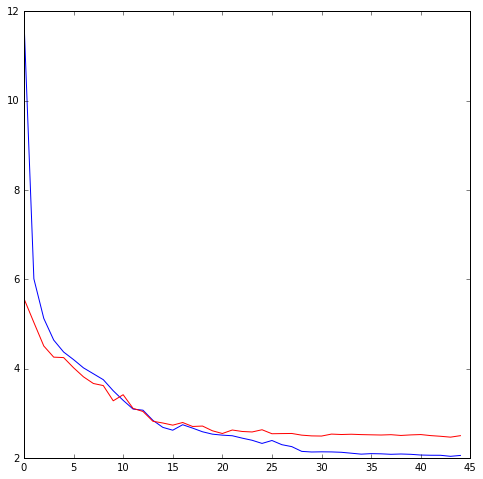

In [751]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [752]:
def get_label_from_num(num):
    if num == 0:
        return 'car'
    elif num == 1:
        return 'bicycle'
    elif num == 2:
        return 'bike'
    elif num == 3:
        return 'person'

In [753]:
swap = lambda im: im.swapaxes(0,1).swapaxes(1,2)

In [846]:
gen = generate_data_2(test_annotations[50:80], C, max_objs=5, size=input_shape)

In [847]:
testdat = [t for t in gen]

In [848]:
Xtest, ytest = testdat[0]

In [761]:
out_fn = theano.function([yl.input], yl.output_test)

In [849]:
Xtest_out = out_fn(Xtest)

In [878]:
N = int(np.random.rand() * Xtest.shape[0])
# N = 0
print N


21


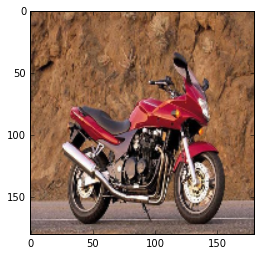

In [879]:
plt.imshow(swap(Xtest[N]))

In [880]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [881]:
coords = yolo.YoloObjectDetector.nms(Xtest_out[N], S, B, C, thresh=.1, overlap=.3 )
print coords.shape

(8, 6)


In [882]:
ytest[N,:8]

array([ 0.14166667,  0.17632242,  0.745     ,  0.80856425,  0.        ,
        0.        ,  1.        ,  0.        ], dtype=float32)

tmp = ytest[N,:]
boxes = []
for i in range(0,tmp.size,8):
    boxes.append(tmp[i:i+4].tolist())
boxes = np.asarray(boxes)

In [883]:
im = utils.draw_coord(swap(Xtest[N]), coords, get_label_from_num)

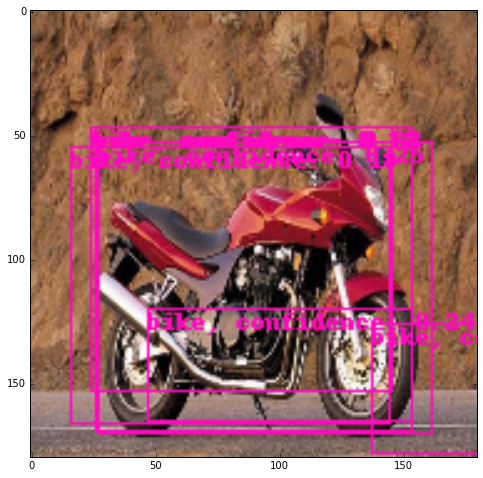

In [884]:
plt.figure(figsize=(8,8))
plt.imshow(im)

In [ ]:
tmp = Xtest_out[N,-4:]
foo = np.argmax(tmp, axis=0)

In [ ]:
plt.imshow(foo, interpolation='none')

In [ ]:
pred = np.copy(Xtest_out[N])
score = pred[[4,9]] * pred[-C:].max(keepdims=True)
score = score.flatten()
args = score.argsort()[::-1][:10]
preds = []
for i in range(args.size):
    idx = np.unravel_index(args[i], pred[[4,9]].shape)
    crd = pred[5*idx[0]:5*idx[0] + 4,idx[1], idx[2]]
    tmp = crd[[2,3]]
    tmp[tmp<1] = 0.5*tmp[tmp<1]**2
    tmp[tmp>=1] = np.abs(tmp[tmp>=1]) - 0.5
    crd[[2,3]] = tmp
    crd = crd.tolist()
    crd[0], crd[1] = crd[0] + np.float_(idx[2]) /S[1], crd[1] + np.float_(idx[1]) / S[0]
    crd.append(score[args[i]])
    preds.append(crd)
preds = np.asarray(preds)

In [ ]:
nms(preds, .3)

In [ ]:
plt.imshow(draw_coord(swap(Xtest[N]), nms(preds, .3)[0], None))

In [ ]:
tmp = np.arange()

In [ ]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [ ]:
N = int(Xtest.shape[0] * np.random.rand())
print N
a, b = draw_best(swap(Xtest[N]), Xtest_out[N], num = 5, thresh=.2)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(a)
print b
# print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
# print c
# print d

In [ ]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)